# ANN for Regression – Non-linear model with GDP analysis


> EXTRA TASK



In [92]:
!pip install -q keras-tqdm

In [93]:
# Data Preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm.keras import TqdmCallback
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [94]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_1"
os.chdir(folder_path)

In [95]:
df = pd.read_csv("data/china_gdp.csv")

# Classic ML

In [96]:
df.head()

,Year,Value
0,1960,5.918412e+10
1,1961,4.955705e+10
2,1962,4.668518e+10
3,1963,5.009730e+10
4,1964,5.906225e+10


In [97]:
print(df.isnull().sum())
print(np.isinf(df).sum())

Year     0
Value    0
dtype: int64
Year     0
Value    0
dtype: int64


In [98]:
df = df.dropna()
df = df[~np.isinf(df).any(axis=1)]

In [99]:
print(df.describe())

             Year         Value
count    55.00000  5.500000e+01
mean   1987.00000  1.437042e+12
std      16.02082  2.500085e+12
min    1960.00000  4.668518e+10
25%    1973.50000  1.395123e+11
50%    1987.00000  3.074796e+11
75%    2000.50000  1.268748e+12
max    2014.00000  1.035483e+13


## Features

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    55 non-null     int64  
 1   Value   55 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1012.0 bytes


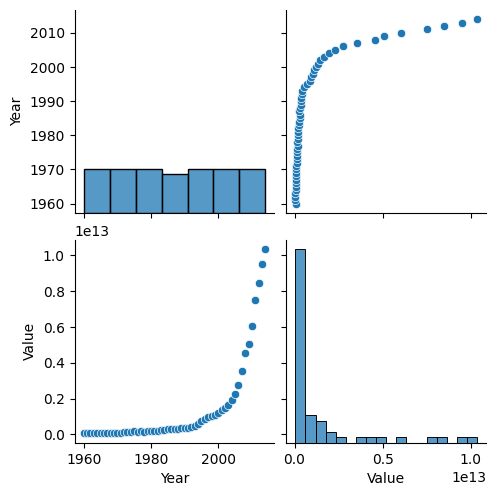

In [101]:
sns.pairplot(df)

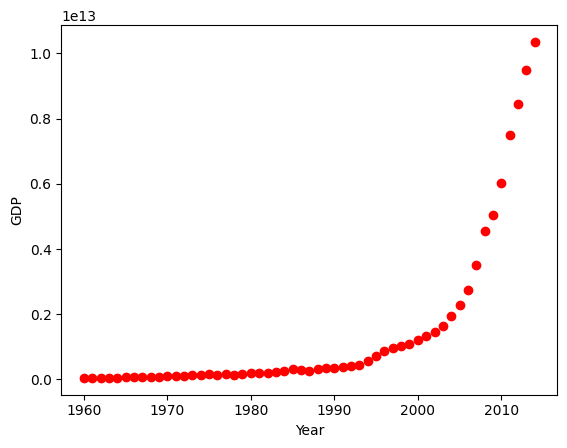

In [102]:
x_data, y_data = (df["Year"].values, df["Value"].values)
plt.plot(x_data, y_data, 'ro')
plt.ylabel('GDP')
plt.xlabel('Year')
plt.show()

> scatter plot shows an exponential relationship between the independent variable (Year) and the dependent variable (GDP Value)



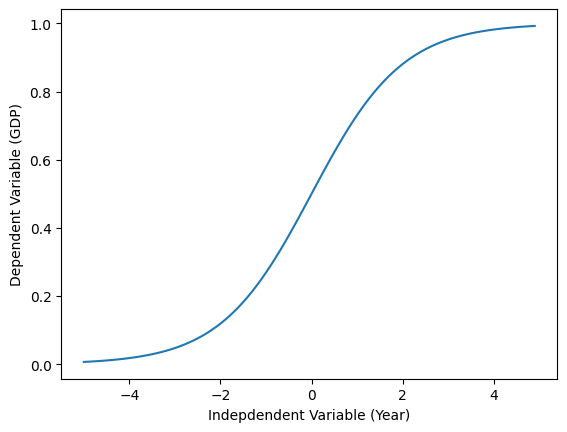

In [103]:
X = np.arange(-5.0, 5.0, 0.1)
Y = 1.0 / (1.0 + np.exp(-X))

plt.plot(X,Y)
plt.ylabel('Dependent Variable (GDP)')
plt.xlabel('Indepdendent Variable (Year)')
plt.show()

## Build the model

In [104]:
def sigmoid(x, Beta_1, Beta_2):
     y = 1 / (1 + np.exp(-Beta_1*(x-Beta_2)))
     return y

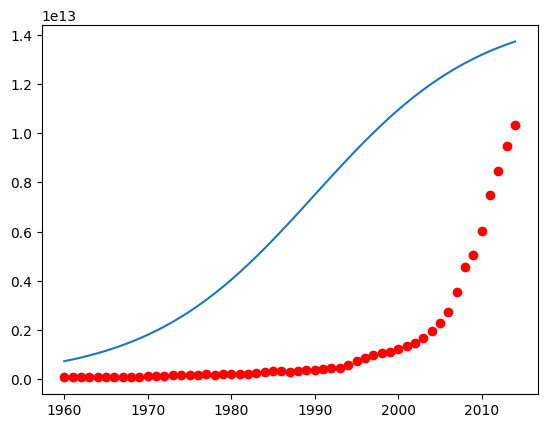

In [105]:
beta_1 = 0.10
beta_2 = 1990.0

#logistic function
Y_pred = sigmoid(x_data, beta_1 , beta_2)

#plot initial prediction against datapoints
plt.plot(x_data, Y_pred*15000000000000.)
plt.plot(x_data, y_data, 'ro')

In [106]:
# Lets normalize our data
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

In [107]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(sigmoid, xdata, ydata)
#print the final parameters
print(" beta_1 = %f, beta_2 = %f" % (popt[0], popt[1]))

 beta_1 = 690.451709, beta_2 = 0.997207


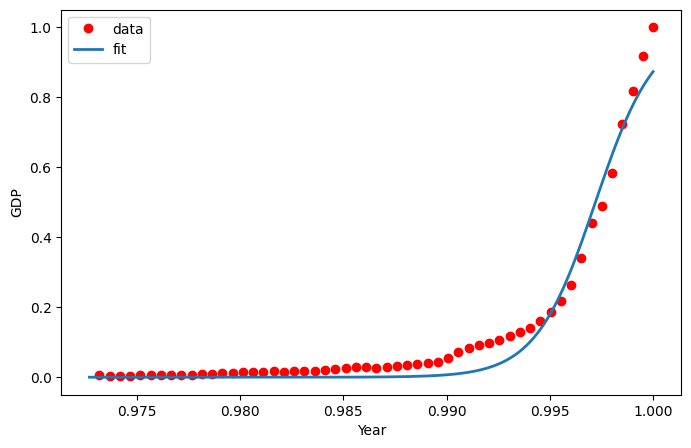

In [108]:
x = np.linspace(1960, 2015, 1000)
x = x/max(x)
plt.figure(figsize=(8,5))
y = sigmoid(x, *popt)
plt.plot(xdata, ydata, 'ro', label='data')
plt.plot(x,y, linewidth=2.0, label='fit')
plt.legend(loc='best')
plt.ylabel('GDP')
plt.xlabel('Year')
plt.show()

## Model Accuracy

In [109]:
# split data into train/test
msk = np.random.rand(len(df)) < 0.8
train_x = xdata[msk]
test_x = xdata[~msk]
train_y = ydata[msk]
test_y = ydata[~msk]

# build the model using train set
popt, pcov = curve_fit(sigmoid, train_x, train_y)

# predict using test set
y_hat = sigmoid(test_x, *popt)

# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(y_hat , test_y) )

Mean absolute error: 0.19
Residual sum of squares (MSE): 0.12
R2-score: -1237902030687904980667885158400.00


<ipython-input-109-02be6cd336a7>:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(sigmoid, train_x, train_y)


# ANN

In [110]:
df = pd.read_csv("data/china_gdp.csv")

In [111]:
df.head()

,Year,Value
0,1960,5.918412e+10
1,1961,4.955705e+10
2,1962,4.668518e+10
3,1963,5.009730e+10
4,1964,5.906225e+10


In [112]:
# Apply logarithmic transformation to the GDP values
df['Value'] = np.log(df['Value'])

# Separate features and target variable
X = df[['Year']].values
y = df['Value'].values
scaler_X = StandardScaler()
# Optionally, scale the 'Year' feature
X_scaled = scaler_X.fit_transform(X)

In [113]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [114]:
regularizers = tf.keras.regularizers

In [115]:
Dense = tf.keras.layers.Dense
Input = tf.keras.layers.Input
Dropout = tf.keras.layers.Dropout
Sequential = tf.keras.models.Sequential
EarlyStopping = tf.keras.callbacks.EarlyStopping

In [116]:
model = Sequential()
model.add(Input(shape=(1,)))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model

model.compile(optimizer='adam', loss='mean_squared_error')

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [117]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=0, callbacks=[early_stopping, TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [118]:
# Make predictions on the test set
y_pred = model.predict(X_test).flatten()

# Convert predictions back to original scale
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [119]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")


Evaluation Metrics:
Mean Absolute Error (MAE): 606130285005.85
Mean Squared Error (MSE): 1585005000089964237553664.00
Root Mean Squared Error (RMSE): 1258969816989.26
R2 Score: 0.7591


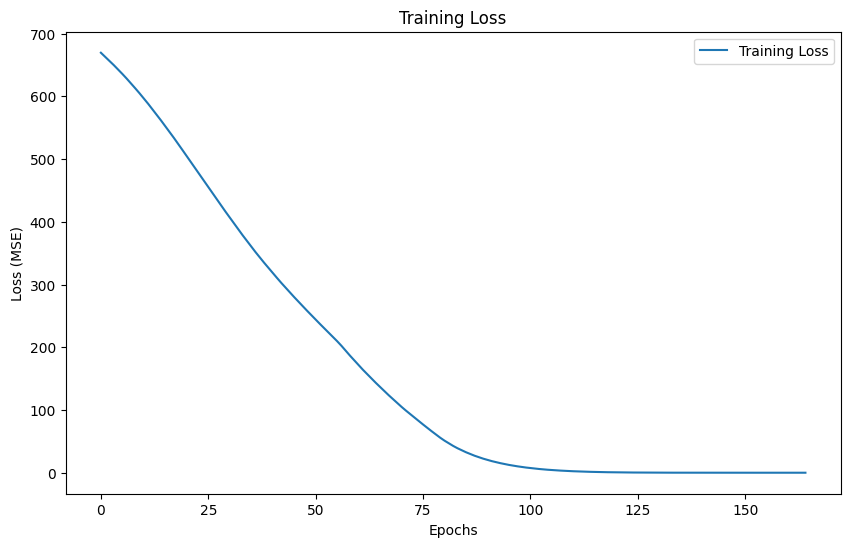

In [120]:
# Plot the training loss over epochs
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

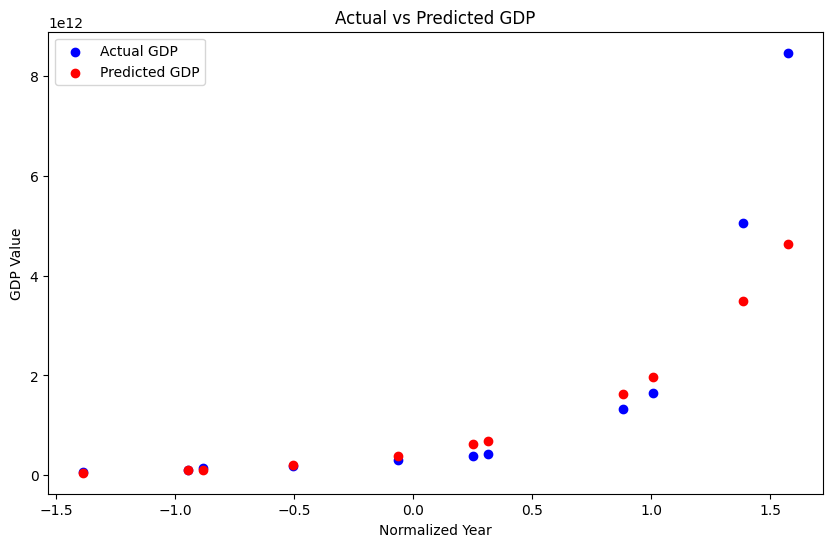

In [121]:
# Plot actual vs predicted GDP
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color='blue', label='Actual GDP')
plt.scatter(X_test, y_pred, color='red', label='Predicted GDP')
plt.title('Actual vs Predicted GDP')
plt.xlabel('Normalized Year')
plt.ylabel('GDP Value')
plt.legend()
plt.show()